# Initialize and load the model

In [1]:
import tensorflow as tf
import numpy as np
from parana.Model import Model
from parana.Layers import fc_layer
from parana.Layers import softmax_layer
from parana.optimizer import optimizer
from parana.optimizer import adamopt
from parana.parameter_saver import saver
import matplotlib.pyplot as plt
import pickle
from parana.parameter_pruning import lobotomizer
from parana.layer_wiggles import get_mean_activations
from parana.wiggles import get_absolute_values
from parana.parameter_selection import get_k_smallest
from parana.parameter_selection import get_k_max

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

path = 'path'

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot = True)

# Tensorflow noise varables and operations,
# noise is added at the input of layer 1
noise = tf.Variable(tf.zeros([784]), name='x_noise')
set_zero_noise = tf.assign(noise, tf.zeros([784]))
noise_placeholder = tf.placeholder('float', [784], name = 'noise_placeholder')
assign_noise = tf.assign(noise, noise_placeholder)

class this_model(Model):
    
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        self.cost_function = 'cross_entropy_l2'
        self.logit_cost_function = 'quadratic_l2'
        self.dropout = 0.7
        self.layers = [fc_layer(inputs=inputs + noise,
                               weight_init = 'xavier',
                               size=1500,
                               weight_decay=0.0001, bias_decay=0.0001)]
        self.layers.append(fc_layer(inputs=self.layers[0].activate, 
                               weight_init = 'xavier',
                               size=800, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs=self.layers[1].activate, 
                               weight_init = 'xavier',
                               size=400, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(softmax_layer(inputs=self.layers[2].activate, 
                                          size=10, 
                                          weight_decay=0.0001, bias_decay=0.0001))
    
X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

mymodel = this_model(X, y)

sess = tf.Session()

# Optimizer for training network
opt = adamopt(sess, 0.00001, mymodel.cost, model =  mymodel)

sess.run(tf.global_variables_initializer())

model_saver = saver(mymodel, sess)

model_saver.load_parameters('model.p'.format(path))

mymodel.zerodropout

print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

C:\Users\Jim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Parameters loaded from  c:/users/jim/tensorflowtrials/ANN_ReLu-Quadratic.p
0.9865


# Get parameter stats

These are for testing output values on pruned models

In [2]:
activationvalues = lobotomizer(session = sess,
                               model = mymodel,
                               layers_list = mymodel.layers,
                               parameters_list = mymodel.get_weights,
                               wigglyness = get_mean_activations,
                               parameter_selection = get_k_smallest,
                               cost = mymodel.cost,
                               data_function = mnist.train.next_batch,
                               X = X, y = y)
activationvalues.get_wigglyness(iterations = 2000)
print('gotit')

absvalues = lobotomizer(session = sess,
                          model = mymodel,
                          parameters_list = mymodel.get_weights,
                          wigglyness = get_absolute_values,
                          parameter_selection = get_k_smallest,
                          cost = mymodel.cost,
                          data_function = mnist.train.next_batch,
                          X = X, y = y)

gotit


# Helper functions

Small functions that are only used in this notebook, not in the parana package yet.

In [3]:
import matplotlib.pyplot as plt
# Gets the 1-2 ratios for a list of outputs
def confidonk(slist):
    conn = []
    for i in slist:
        stort = np.sort(i)
        conn.append(stort[-1]/stort[-2])
    return conn

# Similar ratio using the max output value divided by the sum of the rest, turns out
# not as useful as 1-2 for these models
def onesumratio(slist):
    conn = []
    for i in slist:
        stort = np.sort(i)
        conn.append(stort[-1]/sum(stort[:-2]))
    return conn

# Would be used for setting a cutoff and returning T/F if the values are above or below
# not used in this notebook
def isnoise(confidences, cutoff):
    return [int(abs(i) < cutoff) for i in confidences]

# Returns a list of T/F values if the outputs match the labels
def iscorrect(outputs, labels):
    results = []
    for i in zip(outputs, labels):
        results.append(int(np.argmax(i[0]) == np.argmax(i[1])))
    return results

def noiseset(dataset, labels, vectorlist):
    # Adds noise to 50% of the datapoints, without adding noise of the same class as the datapoint. 
    datapoints = dataset.shape[0]
    gen = np.random.randint(2, size = datapoints)
    noisebatch = []
    classlist = []
    for i in range(datapoints):
        if gen[i] == 1:
            randclass = np.random.randint(len(vectorlist))
            while randclass == np.argmax(labels[i]):
                randclass = np.random.randint(len(vectorlist))
            classlist.append(randclass)
            noisebatch.append(np.clip(dataset[i] + vectorlist[randclass], 0,1))        
        else:
            noisebatch.append(dataset[i])
            classlist.append(None)
    return noisebatch, gen

# Puts outputs into 3 classes, correct with noise added, corrupted by noise and correct without noise
# incorrect classifications with no noise are not returned
def classify_outputs(outputs, labels, gen):
    noisecorrect = []
    noiseincorrect = []
    nonoisecorrect = []

    for i in range(datapoints):
        if gen[i] == 1:
            if np.argmax(labels[i]) == np.argmax(outputs[i]):
                noisecorrect.append(outputs[i])
            if np.argmax(labels[i]) != np.argmax(outputs[i]):
                noiseincorrect.append(outputs[i])
        if gen[i] == 0:
            if np.argmax(labels[i]) == np.argmax(outputs[i]):
                nonoisecorrect.append(outputs[i])
    return abs(np.array(noiseincorrect)), abs(np.array(noisecorrect)), abs(np.array(nonoisecorrect))

# This function plots the cumulative distribution functions seen below
def plot_cutoff(incorrect_noise, correct_noise, no_noise, start, end, step):
    
    incorr_noise = []
    corr_noise = []
    cutoffs = []
    nonoise = []
    cutoff = start
    for i in range(int((end-start)/step)):
        incorr_noise.append(sum(incorrect_noise>cutoff)/len(incorrect_noise))
        corr_noise.append(sum(correct_noise>cutoff)/len(correct_noise))
        nonoise.append(sum(no_noise>cutoff)/len(no_noise))
        cutoffs.append(cutoff)
        cutoff += step
    return incorr_noise,corr_noise, nonoise, cutoffs


# Low/High confidence images.

These cells get the lowest and highest confidence images and plots them to see if they are well written
the first and second highest output values are displayed above the images.

I have run this many times from different random selections of the test set, these are selected with the mnist.train.next_batch() function changing the value changes the number of datapoints chosen to see more high/low confidence images, because this looks at the highest and lowest. 

In [5]:
model_saver.restore_parameters()

#labels = mnist.test.labels
#images = mnist.test.images

batch = mnist.train.next_batch(10000)
images = batch[0]
labels = batch[1]

In [6]:
outputs = sess.run(mymodel.logitoutput, {X:images})
#outputs = sess.run(mymodel.modeloutput, {X:images})

correct_outputs = []
correct_images = []
correct_labels = []
incorrect_outputs = []
incorrect_images = []
incorrect_labels = []

#Split into correct and incorrect
for i in range(len(outputs)):
    if np.argmax(outputs[i]) == np.argmax(labels[i]):
        correct_outputs.append(outputs[i])
        correct_images.append(images[i])
        correct_labels.append(labels[i])
    if np.argmax(outputs[i]) != np.argmax(labels[i]):
        incorrect_outputs.append(outputs[i])
        incorrect_labels.append(labels[i])
        incorrect_images.append(images[i])

correct_confidence = confidonk(correct_outputs)
incorrect_confidence = confidonk(incorrect_outputs)

#correct_confidence = [max(i) for i in correct_outputs]
#incorrect_confidence = [max(i) for i in incorrect_outputs]

# Indices of the lowest confidence images
sorted_indices = np.argsort(np.abs(correct_confidence))

# This list has [[image], [label], [second highest output]]
correct_lowest = []
correct_highest = []

gotsample = []

i = 0
while len(correct_lowest)<9:
    entry = []
    if np.argmax(correct_labels[sorted_indices[i]]) not in gotsample:
        entry.append(correct_images[sorted_indices[i]])
        entry.append(np.argmax(correct_labels[sorted_indices[i]]))
        gotsample.append(np.argmax(correct_labels[sorted_indices[i]]))
        entry.append(np.argsort(correct_outputs[sorted_indices[i]])[-2])
        correct_lowest.append(entry)
    i += 1
i = 1
gotsample=[]
while len(correct_highest)<9:
    entry = []
    if np.argmax(correct_labels[sorted_indices[-i]]) not in gotsample:
        entry.append(correct_images[sorted_indices[-i]])
        entry.append(np.argmax(correct_labels[sorted_indices[-i]]))
        gotsample.append(np.argmax(correct_labels[sorted_indices[-i]]))
        entry.append(np.argsort(correct_outputs[sorted_indices[-i]])[-2])
        correct_highest.append(entry)
    i += 1
correct_highest.sort(key=lambda x: x[1])
correct_lowest.sort(key=lambda x: x[1])

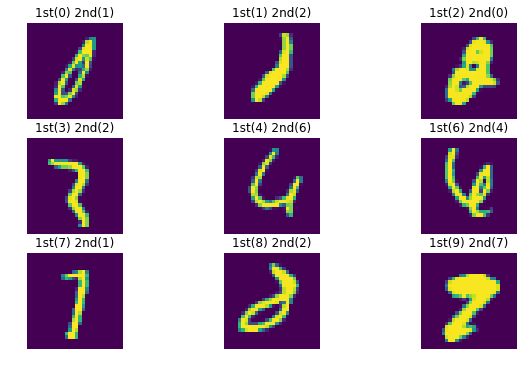

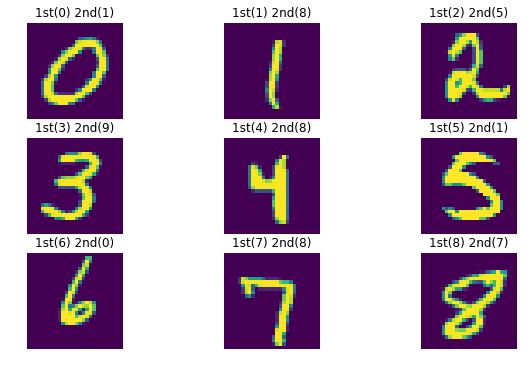

In [7]:

def plot_images(this_list):
    fig = plt.figure()
    for i in range(9):
        plt.subplot(331+i)
        plt.imshow(np.reshape(this_list[i][0], (28, 28)))
        plt.title('1st({}) 2nd({})'.format(this_list[i][1], this_list[i][2]))
        plt.axis('off')

plot_images(correct_lowest)
#print(sess.run(mymodel.logitoutput, {X:[i[0] for i in correct_lowest]}))
plot_images(correct_highest)

# How does noise effect these images?

Adds noise to the images above of the same class as the second highest output value. Makes nice tables. can be tried with different noise vectors if you have them.

       0       1      2       3
0  False   12.40  False   71.89
1  False    6.79  False   13.88
2  False   11.75  False  190.79
3  False   28.09  False  144.59
4  False  328.46  False  261.83
5  False  856.11  False  394.16
6  False   79.95  False   41.85
7  False  104.84  False   59.93
8  False   87.91  False   56.17


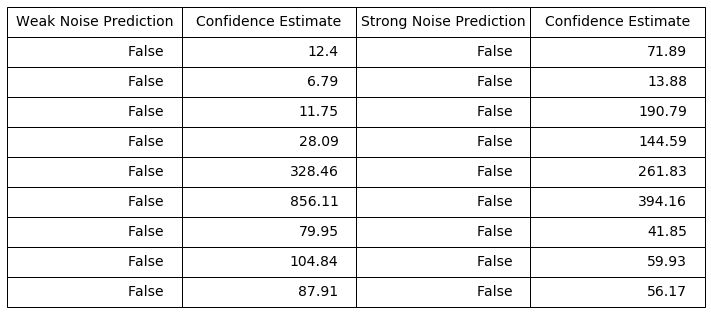

       0         1      2           3
0   True  2.730916  False    2.696892
1  False  1.217430  False    7.786609
2   True  2.277906  False    4.707432
3   True  1.529612  False    4.254043
4   True  1.616379  False    2.216012
5   True  5.412233  False    2.959350
6   True  2.475168  False    4.641391
7   True  1.461915  False   23.009834
8  False  1.572768  False  131.829529


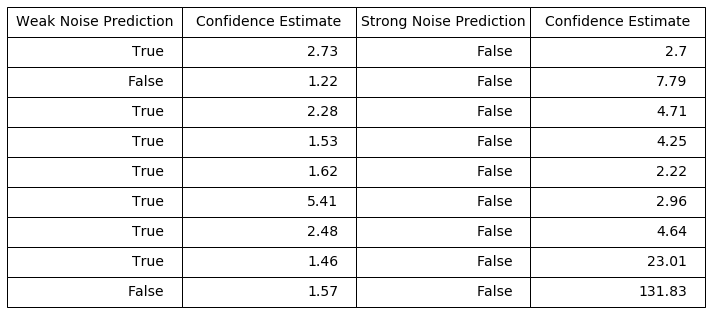

In [8]:
import pandas as pd

path = 'path'
#model_saver.restore_parameters()
weaknoisefiles = ['{}adv_class_0_limit_0.15.p', '{}adv_class_1_limit_0.15.p', '{}adv_class_2_limit_0.15.p', 
             '{}adv_class_3_limit_0.15.p', '{}adv_class_4_limit_0.15.p', '{}adv_class_5_limit_0.15.p',
             '{}adv_class_6_limit_0.15.p', '{}adv_class_7_limit_0.15.p', '{}adv_class_8_limit_0.15.p', 
             '{}adv_class_9_limit_0.15.p']
weaknoiselist = [pickle.load(open(i.format(path), 'rb')) for i in weaknoisefiles]
strongnoisefiles = ['{}adv_class_0_limit_0.35.p', '{}adv_class_1_limit_0.35.p', '{}adv_class_2_limit_0.35.p', 
             '{}adv_class_3_limit_0.35.p', '{}adv_class_4_limit_0.35.p', '{}adv_class_5_limit_0.35.p',
             '{}adv_class_6_limit_0.35.p', '{}adv_class_7_limit_0.35.p', '{}adv_class_8_limit_0.35.p', 
             '{}adv_class_9_limit_0.35.p']
strongnoiselist = [pickle.load(open(i.format(path), 'rb')) for i in strongnoisefiles]

colnames = ['Weak Noise Prediction', 'Confidence Estimate', 'Strong Noise Prediction', 'Confidence Estimate']

def check_noise(image_list):
    output_list = []
    for image in image_list:
        weaknoise = weaknoiselist[image[2]]
        strongnoise = strongnoiselist[image[2]]
        strongnoise_output = sess.run(mymodel.logitoutput, {X:[image[0]+strongnoise]})
        strongsorted = np.sort(strongnoise_output[0])
        strongconfidence = abs(strongsorted[-1]/strongsorted[-2])
        strongcorrect = (np.argmax(strongnoise_output)==image[1])
        weaknoise_output = sess.run(mymodel.logitoutput, {X:[image[0]+weaknoise]})
        weaksorted = np.sort(weaknoise_output[0])
        weakconfidence =abs(weaksorted[-1]/weaksorted[-2])
        weakcorrect = (np.argmax(weaknoise_output) ==image[1])
        output_list.append((weakcorrect, weakconfidence, strongcorrect, strongconfidence))
        
    return output_list

correct_lowest_table = pd.DataFrame(check_noise(correct_lowest))
correct_lowest_table = correct_lowest_table.round(2)
print(correct_lowest_table)
fig = plt.figure(figsize=(5,2))
table = plt.table(cellText = correct_lowest_table.values,
                  colLabels = colnames,
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.5, 2.5)
plt.axis('off')
plt.grid('off')
plt.show()
print(pd.DataFrame(check_noise(correct_highest)))

correct_highest_table = pd.DataFrame(check_noise(correct_highest))
correct_highest_table = correct_highest_table.round(2)
fig = plt.figure(figsize=(5,2))
table = plt.table(cellText = correct_highest_table.values,
                  colLabels = colnames,
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.5, 2.5)
plt.axis('off')
plt.grid('off')
plt.show()

In [9]:
activationvalues.prune_step(0.83)

In [20]:
model_saver.restore_parameters()
path = 'path'

noisefiles = ['{}adv_class_0_limit_0.35.p', '{}adv_class_1_limit_0.35.p', '{}adv_class_2_limit_0.35.p', 
             '{}adv_class_3_limit_0.35.p', '{}adv_class_4_limit_0.35.p', '{}adv_class_5_limit_0.35.p',
             '{}adv_class_6_limit_0.35.p', '{}adv_class_7_limit_0.35.p', '{}adv_class_8_limit_0.35.p', 
             '{}adv_class_9_limit_0.35.p']

noiselist = [pickle.load(open(i.format(path), 'rb')) for i in noisefiles]

# 1-2 ratio

These next few cells plot cumulitive distribution functions of 1-2 ratio values.

Test accuracy without noise
0.9865
Batch accuracy with 50% noise
0.552


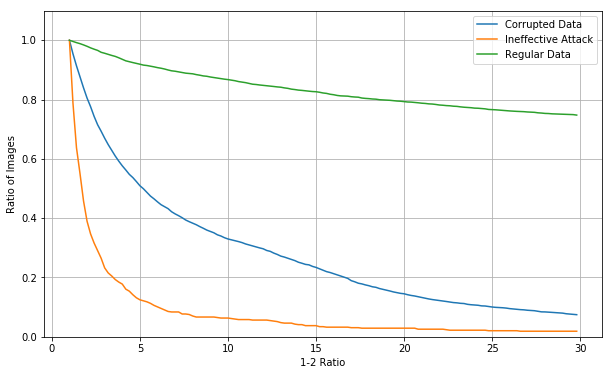

18.199999999999967
0.16870748299319727
0.8020263424518743


In [21]:
mymodel.zerodropout
model_saver.restore_parameters()
print('Test accuracy without noise')
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

datapoints = 10000
batch = mnist.train.next_batch(datapoints)

noisebatch, gen = noiseset(mnist.test.images, mnist.test.labels, noiselist)

print('Batch accuracy with 50% noise')
print(mymodel.accuracy(sess,inputs =  noisebatch, labels =  mnist.test.labels))

outputs = (sess.run(mymodel.logitoutput, {X: noisebatch}))

incorrect_noise_confidence, correct_noise_confidence, no_noise_confidence = classify_outputs(outputs, mnist.test.labels, gen)
incorrect_noise_confidence = np.array(confidonk(incorrect_noise_confidence))
correct_noise_confidence = np.array(confidonk(correct_noise_confidence))
no_noise_confidence = np.array(confidonk(no_noise_confidence))


badnoise,somenoise, goodnoise, cutoffs = plot_cutoff(incorrect_noise_confidence, correct_noise_confidence,
                                 no_noise_confidence,
                                 start = 1, end = 30, step = 0.2)

plt.plot(cutoffs, badnoise, label='Corrupted Data')
plt.plot(cutoffs, somenoise, label='Ineffective Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()
print(cutoffs[86])
print(badnoise[86])
print(goodnoise[86])

Test accuracy without noise
0.9744
batch accuracy with noise
0.7459


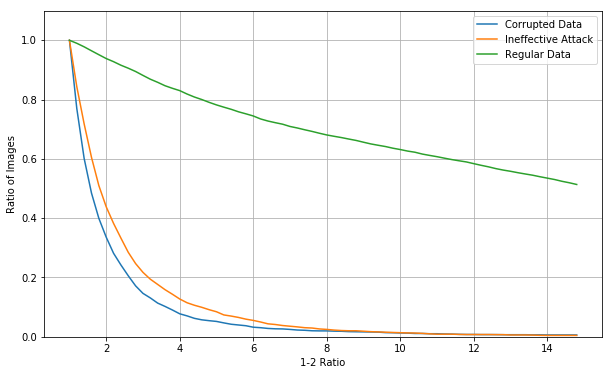

7.0000000000000036
0.024896265560165973
0.7093717816683831


In [12]:
model_saver.restore_parameters()
activationvalues.prune_step(0.85)
print('Test accuracy without noise')
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

datapoints = 10000
batch = mnist.train.next_batch(datapoints)

noisebatch, gen = noiseset(mnist.test.images, mnist.test.labels, noiselist)

print('batch accuracy with noise')
print(mymodel.accuracy(sess, inputs =  noisebatch, labels = mnist.test.labels))

outputs = (sess.run(mymodel.logitoutput, {X: noisebatch}))

incorrect_noise_confidence, correct_noise_confidence, no_noise_confidence = classify_outputs(outputs, mnist.test.labels, gen)
incorrect_noise_confidence = np.array(confidonk(incorrect_noise_confidence))
correct_noise_confidence = np.array(confidonk(correct_noise_confidence))
no_noise_confidence = np.array(confidonk(no_noise_confidence))

badnoise,somenoise, goodnoise, cutoffs = plot_cutoff(incorrect_noise_confidence, correct_noise_confidence,
                                 no_noise_confidence,
                                 start = 1, end = 15, step = 0.2)
plt.plot(cutoffs, badnoise, label='Corrupted Data')
plt.plot(cutoffs, somenoise, label='Ineffective Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()
print(cutoffs[30])
print(badnoise[30])
print(goodnoise[30])

Test accuracy without noise
0.9837
batch accuracy with 50% noise
0.6945


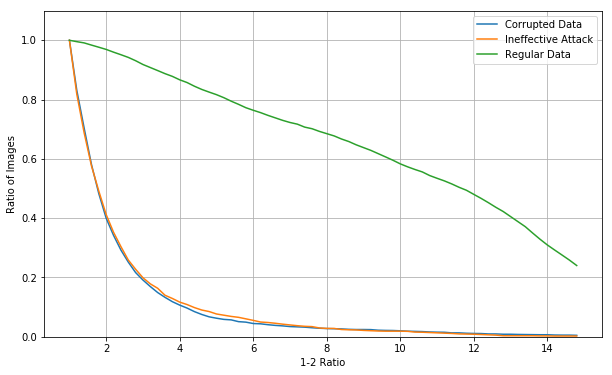

5.600000000000002
0.051094890510948905
0.7840272217774219


In [13]:
model_saver.restore_parameters()
absvalues.prune_step(0.88)
print('Test accuracy without noise')
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

datapoints = 10000
batch = mnist.train.next_batch(datapoints)

noisebatch, gen = noiseset(batch[0], batch[1], noiselist)

print('batch accuracy with 50% noise')
print(mymodel.accuracy(sess, inputs =  noisebatch, labels =  batch[1]))

outputs = (sess.run(mymodel.logitoutput, {X: noisebatch}))

incorrect_noise_confidence, correct_noise_confidence, no_noise_confidence = classify_outputs(outputs, batch[1], gen)
incorrect_noise_confidence = np.array(confidonk(incorrect_noise_confidence))
correct_noise_confidence = np.array(confidonk(correct_noise_confidence))
no_noise_confidence = np.array(confidonk(no_noise_confidence))

badnoise,somenoise, goodnoise, cutoffs = plot_cutoff(incorrect_noise_confidence, correct_noise_confidence,
                                 no_noise_confidence,
                                 start = 1, end = 15, step = 0.2)

plt.plot(cutoffs, badnoise, label='Corrupted Data')
plt.plot(cutoffs, somenoise, label='Ineffective Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()
print(cutoffs[23])
print(badnoise[23])
print(goodnoise[23])

# Output values

This plots the CDF and a histogram of output values, I should make some histograms of 1-2 ratios, but the values are over a much bigger range. 

Interesting to watch how this plot changes with different pruning ratios set by activationvalues.prune_step() and absvalues.prune_step()

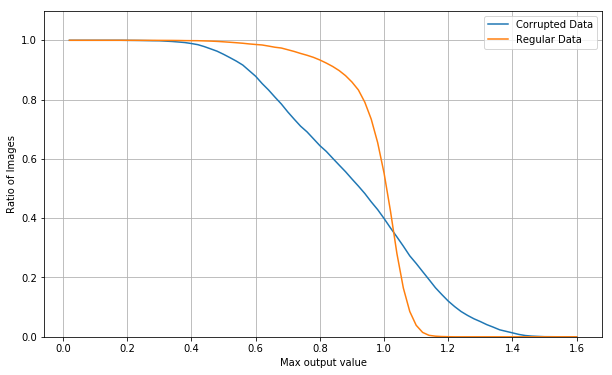

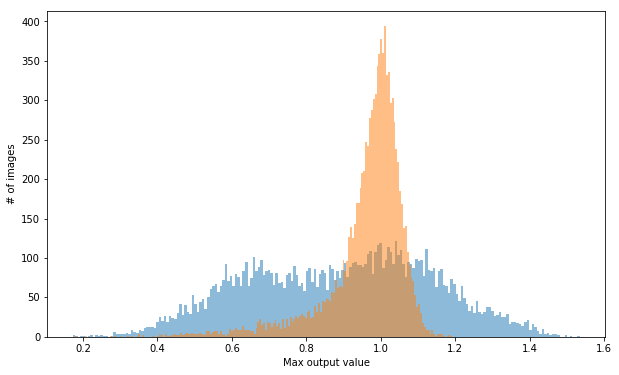

In [26]:
model_saver.restore_parameters()
#activationvalues.prune_step(0.75)
#absvalues.prune_step(0.7)
datapoints = 20000
batch = mnist.train.next_batch(datapoints)

noisebatch, gen = noiseset(batch[0], batch[1], noiselist)

outputs = (sess.run(mymodel.logitoutput, {X: noisebatch}))

noisy = []
quiet = []

for i in range(datapoints):
    if gen[i] == 1:
        noisy.append(max(outputs[i]))
    if gen[i] == 0:
        quiet.append(max(outputs[i]))
noisy = np.array(noisy)
quiet = np.array(quiet)

noisyratios = []
quietratios = []
cutoffs = []
cutoff = 0
for i in range(80):
    noisyratios.append(sum(noisy>cutoff)/len(noisy))
    quietratios.append(sum(quiet>cutoff)/len(quiet))
    cutoff += 0.02
    cutoffs.append(cutoff)

plt.plot(cutoffs, noisyratios, label='Corrupted Data')
plt.plot(cutoffs, quietratios, label='Regular Data')
#plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('Max output value')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()

plt.hist(noisy, bins=200, alpha=0.5, label='Corrupted Data')
plt.hist(quiet, bins=200, alpha=0.5, label='Corrupted Data')
plt.xlabel('Max output value')
plt.ylabel('# of images')
plt.show()

# 1-sum ratio

This is just a test of a different confidence value, not as useful for this model and dataset. Could be useful for others...

Test accuracy without noise
0.9865
Batch accuracy with 50% noise
0.6193


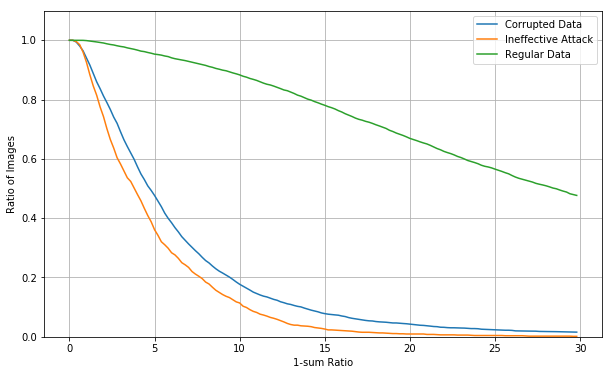

12.999999999999986
0.10909575886903174
0.8252024081378452


In [15]:
mymodel.zerodropout
model_saver.restore_parameters()
#activationvalues.prune_step(0.85)
print('Test accuracy without noise')
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

datapoints = 10000
batch = mnist.train.next_batch(datapoints)

noisebatch, gen = noiseset(mnist.test.images, mnist.test.labels, noiselist)

print('Batch accuracy with 50% noise')
print(mymodel.accuracy(sess,inputs =  noisebatch, labels =  mnist.test.labels))

outputs = (sess.run(mymodel.logitoutput, {X: noisebatch}))

incorrect_noise_confidence, correct_noise_confidence, no_noise_confidence = classify_outputs(outputs, mnist.test.labels, gen)
incorrect_noise_confidence = np.array(onesumratio(incorrect_noise_confidence))
correct_noise_confidence = np.array(onesumratio(correct_noise_confidence))
no_noise_confidence = np.array(onesumratio(no_noise_confidence))


badnoise,somenoise, goodnoise, cutoffs = plot_cutoff(incorrect_noise_confidence, correct_noise_confidence,
                                 no_noise_confidence,
                                 start = 0, end = 30, step = 0.2)

plt.plot(cutoffs, badnoise, label='Corrupted Data')
plt.plot(cutoffs, somenoise, label='Ineffective Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-sum Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()
print(cutoffs[65])
print(badnoise[65])
print(goodnoise[65])